## Graph Mining

#### Davy

In [1]:
# Reload local python files every 2 seconds
            
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time

import matplotlib.pyplot as plt

from PageRank import *

### Section 1: Implementation of Power Iteration Algorithm

##### (A)Implement the power iteration algorithm in matrix form to calculate the rank vector r, without teleport, using the PageRank formulation:
<center>$r^{(t+1)} = M \cdot r^{(t)}$</center>

##### The matrix $M$ is an adjacency matrix representing nodes and edges from your downloaded dataset, with rows representing destination nodes and columns representing source nodes. This matrix is sparse. Initialize $r^{(0)}$ = $[1/N, . . . , 1/N]^T$ . Let the stop criteria of your power iteration algorithm be $||r^{(t+1)} − r^{(t)}||_1 < 0.02 $(please note the stop criteria involves the $L_1$ norm). Spider traps and dead ends are not considered in this first task.

In [3]:
# reading data from *.txt file

path = "web-BerkStan-final.txt"

try:
    with open(path,'r') as file:
        data = [ line.strip('\n').split('\t') for line in file]
        edges = [ [ int(x) for x in row ] for row in data ]
    file.close()
    
except FileNotFoundError:
    print("file open failed.")


ID = float('-inf')

#counting total nodes
for row in edges:
    for element in row:
        if element > ID:
            ID = element

N =  ID + 1
L = len(edges)

print(f'The graph includes {N} nodes.\n')
print(f'The graph includes {L} edges.\n')

The graph includes 685230 nodes.

The graph includes 7600595 edges.



##### (B)Run your code on the Berkeley-Stanford web data to calculate the rank score for all the nodes. Report: (1) The running time of your power iteration algorithm; (2) The number of iterations needed to stop; (3) The IDs and scores of the top-10 ranked nodes.

In [4]:
t0 = time.time()
Sparse_Matrix, Col_sums, Iters, Vecs = Power_Interation(N, edges, 0.02)
t1 = time.time()

Time_consume = t1 - t0

Creating the sparse matrix...

[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]
Calculating the summation of the columns...
[[ 9.  8.  2. ... 13. 13. 13.]]
Initialising the weight of the sparse matrix...
Completed.

[[0.         0.         0.5        ... 0.         0.         0.        ]
 [0.11111111 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.07692308 0.07692308]
 [0.         0.         0.         ... 0.07692308 0.         0.07692308]
 [0.         0.         0.         ... 0.07692308 0.07692308 0.        ]]
Initialising the vector_0...
Completed.

Looping...
This is the iterations of 50.

This is the iterations of 100.

This is the iterations of 150.

This is the iterations of 200.

This is the iterations of 250.

This is the iterations

In [5]:
print(f'The running time of my power iteration algorithm is :{Time_consume}\n')
print(f'The number of iterations needed to stop is {Iters}\n')

The running time of my power iteration algorithm is :15.56163215637207

The number of iterations needed to stop is 501



In [6]:
nodes_score = {}

Items = list(Vecs.items())
Last_Vector = Items[-1]

for i,vec in enumerate(Last_Vector[1]):
    nodes_score[i] = vec

sorted_nodes_score = dict(sorted(nodes_score.items(), key=lambda item: item[1], reverse=True))

In [7]:
print('The IDs and scores of the top-10 ranked nodes.\n')

Top_10= list(sorted_nodes_score.items())[:10]

for key, value in Top_10:
    print(f'ID:{key}  Score:{value:.6f}')

The IDs and scores of the top-10 ranked nodes.

ID:49175  Score:0.006558
ID:50301  Score:0.005644
ID:316711  Score:0.004669
ID:590181  Score:0.003339
ID:50306  Score:0.002800
ID:50307  Score:0.002800
ID:446912  Score:0.002598
ID:66243  Score:0.002229
ID:68948  Score:0.002227
ID:68947  Score:0.002207


### Section 2:Understanding dead-ends


##### (A) Calculate and report the number of dead-end nodes in your matrix $M$.

In [8]:
zero_indices = np.argwhere(Col_sums == 0)
dead_nodes = {(index[0], index[1]): 0 for index in zero_indices}

In [9]:
print(f'The number of dead-end nodes in my matrix is {len(dead_nodes)}.\n')

The number of dead-end nodes in my matrix is 4744.



##### (B)Calculate the leaked PageRank score in each iteration of Task 1 (B). The leaked PageRank score is the total score you lose in that iteration because of dead-ends (hint: see example on slide 2 of W6.3 lecture notes). Create a plot that shows how this leaked score behaves as iterations progress. Explain the phenomenon you observe from this visualization.

In [10]:
leaked_score = {}

for iter in range(Iters):
    r_t= Items[ iter ][1]
    leaked_score[ iter ] =1 - np.sum(r_t)

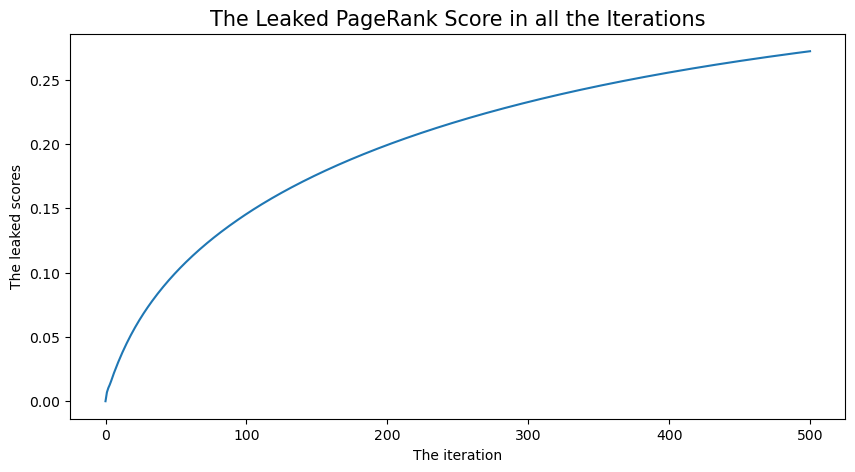

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(range(Iters),leaked_score.values() )

plt.tick_params(labelsize=10)

plt.xlabel('The iteration',size = 10)
plt.ylabel('The leaked scores',size = 10)
plt.title('The Leaked PageRank Score in all the Iterations',size =15)

plt.show()

**Summary**:
In the above plot, we can easily identify that when iteration increases, the leaked score increases. 

**Reason**:
Those pages do not have out-links and the information propagates to dead ends will leak out.

### Section 3: Implementation of Power Iteration with Teleport.

##### (A)Extend your PageRank code to handle both spider traps and dead ends using the idea of teleport. In this task, your implementation will allow to teleport randomly to any node. Code the PageRank with teleport formulation that, using the sparse matrix $M$, for each iteration works in three steps (slide 8 of W6.3 lecture notes):
- Step 1: Calculate the $r$ ranks of current iteration **$r^{new}$** (in matrix form):
  <center>$r^{new} =\beta M·r^{old}$</center>
- Step 2: Calculate the constant S for teleport:
<center>$S = \sum_{j} r^{new}_j$</center>
- Step 3: Update $r^{new}$ with teleport:
<center>$r^{new} = r^{new} + (1 − S)/N$</center>
In your implementation, use $\beta= 0.9$. Initialize $r^{(0)} = [1/N,...,1/N]^T$. The stop criteria should be $||r^{new} − r^{old}||_1 < 0.02$.

##### (B) Run your code on the Berkeley-Stanford web data to calculate the rank score for all the nodes. Report: (1) The running time; (2) The number of iterations needed to stop; (3) The IDs and scores of the top-10 ranked nodes.

In [12]:
t_old = time.time()
Sparse_Matrix2, Col_sums2, Iters2, R_new_Vecs = Power_Interation_with_Teleport(N, edges, 0.02, 0.9)
t_new = time.time()

Time_consume2 = t_new - t_old

Creating the sparse matrix...

[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]
Calculating the summation of the columns...
[[ 9.  8.  2. ... 13. 13. 13.]]
Initialising the weight of the sparse matrix...
Completed.

Initialising the vector_0...
Completed.

Looping...
Beta is 0.9.

The final result has been generated!


In [13]:
print(f'The running time of my power iteration algorithm is :{Time_consume2}\n')
print(f'The number of iterations needed to stop is {Iters2}\n')

The running time of my power iteration algorithm is :7.531558990478516

The number of iterations needed to stop is 12



In [14]:
nodes_score2 = {}

Items2 = list(R_new_Vecs.items())
Last_Vector2 = Items2[-1]

for i,vec in enumerate(Last_Vector2[1]):
    nodes_score2[i] = vec

sorted_nodes_score2 = dict(sorted(nodes_score2.items(), key=lambda item: item[1], reverse=True))

In [15]:
print('The IDs and scores of the top-10 ranked nodes.\n')

Top_10_2= list(sorted_nodes_score2.items())[:10]

for key, value in Top_10_2:
    print(f'ID:{key}  Score:{value:.6f}')

The IDs and scores of the top-10 ranked nodes.

ID:272918  Score:0.009991
ID:438237  Score:0.007288
ID:210375  Score:0.004514
ID:210304  Score:0.004406
ID:601655  Score:0.003995
ID:571447  Score:0.003663
ID:316791  Score:0.003087
ID:571446  Score:0.002320
ID:319208  Score:0.002236
ID:184093  Score:0.002232


##### (C) Vary the teleport probability $\beta$ with numbers in the set: {1, 0.9, 0.8, 0.7, 0.6}. Report the number of iterations needed to stop for each $\beta$. Explain, in words, your findings from this experiment.

In [16]:
Beta =  [i / 10 for i in range(10, -1, -1)] 

Iterations = {} 

for b in Beta :
    Sparse_Matrix2, Col_sums2, Iters3, R_new_Vecs2 = Power_Interation_with_Teleport(N, edges, 0.015, b)
    Iterations[ b ] = Iters3 

Creating the sparse matrix...

[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]
Calculating the summation of the columns...
[[ 9.  8.  2. ... 13. 13. 13.]]
Initialising the weight of the sparse matrix...
Completed.

Initialising the vector_0...
Completed.

Looping...
Beta is 1.0.

This is the iterations of 50.

This is the iterations of 100.

This is the iterations of 150.

This is the iterations of 200.

This is the iterations of 250.

This is the iterations of 300.

This is the iterations of 350.

This is the iterations of 400.

This is the iterations of 450.

This is the iterations of 500.

This is the iterations of 550.

This is the iterations of 600.

This is the iterations of 650.

This is the iterations of 700.

This is the iterations of 750.

This is the iterations of 800.

This is the iterations of 850.

This is the iterations of 900.

This is the iterations of 950.

This

In [17]:
Pairs = list(Iterations.items())

for key, value in Pairs:
    print(f'When probability beta is {key}, number of iterations needed to stop is {value}.\n')

When probability beta is 1.0, number of iterations needed to stop is 5226.

When probability beta is 0.9, number of iterations needed to stop is 14.

When probability beta is 0.8, number of iterations needed to stop is 9.

When probability beta is 0.7, number of iterations needed to stop is 7.

When probability beta is 0.6, number of iterations needed to stop is 5.

When probability beta is 0.5, number of iterations needed to stop is 5.

When probability beta is 0.4, number of iterations needed to stop is 4.

When probability beta is 0.3, number of iterations needed to stop is 3.

When probability beta is 0.2, number of iterations needed to stop is 3.

When probability beta is 0.1, number of iterations needed to stop is 2.

When probability beta is 0.0, number of iterations needed to stop is 1.



**Experiement Findings**

Bata infers the probability that nodes follow the out-link to propagate the information and 1 minus bata follows a node randomly jumping to a node. As we can see when bata equals 1, then all the dead-nodes will not select a node to teleport. However, while the probability does not equal to 1, the iteration will have a sharp drop. Further more, the probability drops, and the iterations drops.   
